In [1]:
import PyPlot
const plt = PyPlot
using Distributions, StatsBase, DataFrames
include("ZZ_dominated_Hessian.jl")
include("ZZ_subsampling.jl")

acf (generic function with 1 method)

In [2]:
function logistic_data(d, Nobs) 
    X = ones(d, Nobs)
    y = zeros(Nobs)
    y[1] = 1
    y = rand(Binomial(1,0.1), Nobs)
    return X, y
end

logistic_data (generic function with 1 method)

#### $1$-dimensional examples

In [3]:
d, Nobs = 1, 10^4
n_1, n_2 = 10^3, 10^4
X, y = logistic_data(d, Nobs);

In [4]:
β_0 = ones(d)
Print = false
σ = 10
A = eye(d);

In [5]:
max_attempts = 10^5
N_samples = copy(max_attempts)
weights = nothing 
replace = false
root = find_root(X, y, σ);

In [6]:
start = time()
s_dh_1, b_dh_1 = ZZ_dominated_Hessian(X[:,1:n_1], y[1:n_1], max_attempts, β_0, σ, A) 
s_dh_2, b_dh_2 = ZZ_dominated_Hessian(X[:,1:n_2], y[1:n_2], max_attempts, β_0, σ, A) 
s_cv_1, b_cv_1 = ZZ_logistic(X[:,1:n_1], y[1:n_1], max_attempts, β_0, n_1, root, σ, A, true, weights, replace)
s_cv_2, b_cv_2 = ZZ_logistic(X[:,1:n_2], y[1:n_2], max_attempts, β_0, n_2, root, σ, A, true, weights, replace)
print( round((time()-start)/60, 2), " minutes to run \n")
samples_dh_1 = extract_samples(s_dh_1, b_dh_1, b_dh_1[end]/N_samples)
samples_dh_2 = extract_samples(s_dh_2, b_dh_2, b_dh_2[end]/N_samples)
samples_cv_1 = extract_samples(s_cv_1, b_cv_1, b_cv_1[end]/N_samples)
samples_cv_2 = extract_samples(s_cv_2, b_cv_2, b_cv_2[end]/N_samples)
print("Configuration temperatures: \n")
print("dH: ", round.([compute_configT(samples_dh_1, i, X[:,1:n_1], y[1:n_1], n_1, σ) for i in 1:d], 2),
              round.([compute_configT(samples_dh_2, i, X[:,1:n_2], y[1:n_2], n_2, σ) for i in 1:d], 2), "\n") 
print("cv: ", round.([compute_configT(samples_cv_1, i, X[:,1:n_1], y[1:n_1], n_1, σ) for i in 1:d], 2),
              round.([compute_configT(samples_cv_2, i, X[:,1:n_2], y[1:n_2], n_2, σ) for i in 1:d], 2), "\n")

28.0% of switches accepted 
28.0% of switches accepted 
10.0% of switches accepted 
12.0% of switches accepted 
41.97 minutes to run 
Configuration temperatures: 
dH: [1.13][1.52]
cv: [1.03][2.37]


In [7]:
b_dh_1[end], b_dh_2[end]

(7413.848532861708, 2343.004360992135)

In [8]:
acf_pg_1 = DataFrames.readtable("acf_pg_1.csv", header=false)[:x1]
acf_pg_2 = DataFrames.readtable("acf_pg_2.csv", header=false)[:x1];

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #readtable#232(::Bool, ::Char, ::Array{Char,1}, ::Char, ::Array{String,1}, ::Array{String,1}, ::Array{String,1}, ::Bool, ::Int64, ::Array{Symbol,1}, ::Array{Any,1}, ::Bool, ::Char, ::Bool, ::Int64, ::Array{Int64,1}, ::Bool, ::Symbol, ::Bool, ::Bool, ::DataFrames.#readtable, ::String) at /home/postdoc/dsen/.julia/v0.6/DataFrames/src/deprecated.jl:1045
 [3] (::DataFrames.#kw##readtable)(::Array{Any,1}, ::DataFrames.#readtable, ::String) at ./<missing>:0
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] softscope_include_string(::Module, ::String, ::String) at /home/postdoc/dsen/.julia/v0.6/SoftGlobalScope/src/SoftGlobalScope.jl:66
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/postdoc/dsen/.julia/v0.6/IJulia/src/execute_request.jl:193
 [7] (::Compat.#inner#6{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/postdoc/dsen/.julia/v0.6/Compat/src/Compat.jl:189
 [8] e

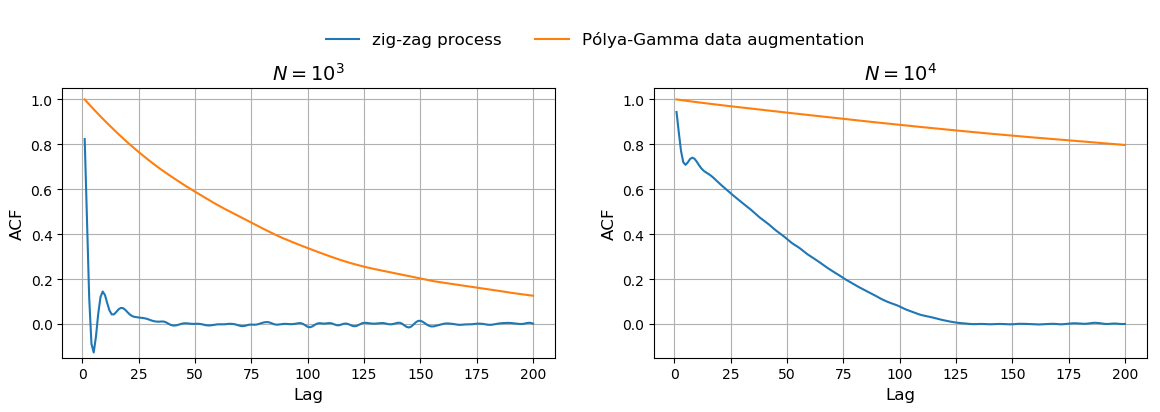

In [45]:
using PyPlot
fig = figure("pyplot_subplot_mixed",figsize=(14,3.5))
maxlag = 200
a, b = -0.15, 1.05

subplot(121) 
title(L"$N = 10^3$", fontsize=14)
plot(1:maxlag, acf(samples_dh_1[1,:], maxlag), label="zig-zag process")
#plot(1:maxlag, acf(samples_cv_1[1,:], maxlag), label="zig-zag with control variates")
plot(1:maxlag, acf_pg_1, label="Pólya-Gamma data augmentation")
grid("on")
ylabel("ACF", fontsize=12)
xlabel("Lag", fontsize=12)
ylim([a,b])

subplot(122) 
title(L"$N = 10^4$", fontsize=14)
plot(1:maxlag, acf(samples_dh_2[1,:], maxlag))
plot(1:maxlag, acf_pg_2)
grid("on")
ylabel("ACF", fontsize=12)
xlabel("Lag", fontsize=12)
ylim([a,b])

plt.figlegend(ncol=2,loc="upper center", bbox_to_anchor = (0,0.13,0.85,1), frameon=false, fontsize=12)

plt.savefig("1d_ACF.pdf", format="pdf", dpi=10000, bbox_inches="tight")